#### Imports are Necessary

In [1]:
import torch
from rpn.build_rpn import RPN_Model
from sam.build_sam import SAM_Model
from data_builder.build_dataset import PlanetscopeDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import linear_sum_assignment

#### Usual Definition

In [2]:
ROOT_PATH = 'C://Users/anind/Dropbox (ASU)/ASU/Kerner-Lab/SAT-SAM(Dataset)/ps_france/all_dataset/'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#### Model Definition

In [3]:
rpn_model = RPN_Model('rpn/checkpoint/rpn_model_1.14_Fr_Rw.pth', 2, device)
sam_model = SAM_Model('sam/checkpoint/sam_vit_l_0b3195.pth', 'large', device)

#### Dataset Definition

In [4]:
dataset = PlanetscopeDataset(ROOT_PATH, train=False)

In [5]:
rgb_image, transformed_image, target, ensemble_layer = dataset[300]

#### Region Proposal Network

In [6]:
predictions = rpn_model.predict(transformed_image)
predictions = rpn_model.postprocess(predictions, nms_threshold=0.9, score_threshold=0.6)

#### Reduce the number of boxes based on the ensemble layer

In [7]:
def filter_boxes(predictions, ensemble, overlap):
    ensemble = ensemble.astype(np.uint8)
    filtered_boxes = []

    for i in range (len(predictions['boxes'])):
        xmin = predictions['boxes'][i][0]
        ymin = predictions['boxes'][i][1]
        xmax = predictions['boxes'][i][2]
        ymax = predictions['boxes'][i][3]
        
        box_mask = np.zeros((ensemble.shape[0], ensemble.shape[1]))
        box_mask[int(ymin):int(ymax), int(xmin):int(xmax)] = 1
        num_ones_box = np.count_nonzero(box_mask)
        res = ensemble * box_mask
        num_ones_intersection = np.count_nonzero(res)

        # print("Number of ones in the box: ", num_ones_box)
        # print("Number of ones in the intersection: ", num_ones_intersection)

        _overlap = num_ones_intersection / num_ones_box
        # print("Overlap: ", _overlap)

        if _overlap > overlap:
            filtered_boxes.append(predictions['boxes'][i])

    return filtered_boxes

In [8]:
filtered_predictions = filter_boxes(predictions, ensemble_layer, 0.5)
# filtered_predictions = predictions['boxes']

#### Plot the Predicted & Ground Truth Boxes

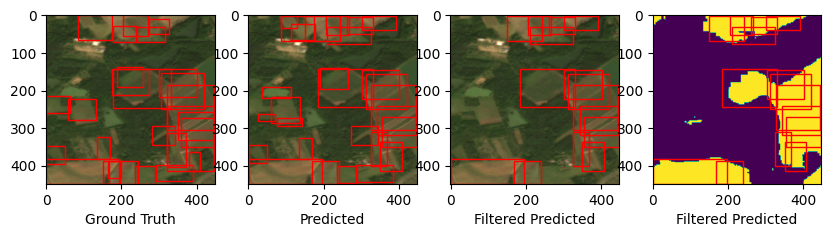

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5))

ax[0].imshow(rgb_image)
ax[0].set_xlabel('Ground Truth')

for i in range (len(target['boxes'])):
    xmin = target['boxes'][i][0]
    
    ymin = target['boxes'][i][1]
    xmax = target['boxes'][i][2]
    ymax = target['boxes'][i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)

ax[1].imshow(rgb_image)
ax[1].set_xlabel('Predicted')

for i in range (len(predictions['boxes'])):
    xmin = predictions['boxes'][i][0]
    ymin = predictions['boxes'][i][1]
    xmax = predictions['boxes'][i][2]
    ymax = predictions['boxes'][i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)

ax[2].imshow(rgb_image)
ax[2].set_xlabel('Filtered Predicted')

for i in range (len(filtered_predictions)):
    xmin = filtered_predictions[i][0]
    ymin = filtered_predictions[i][1]
    xmax = filtered_predictions[i][2]
    ymax = filtered_predictions[i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)


ax[3].imshow(ensemble_layer)
ax[3].set_xlabel('Filtered Predicted')

for i in range (len(filtered_predictions)):
    xmin = filtered_predictions[i][0]
    ymin = filtered_predictions[i][1]
    xmax = filtered_predictions[i][2]
    ymax = filtered_predictions[i][3]
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
    ax[3].add_patch(rect)


plt.show()

#### Segment Anything Model

In [10]:
low_res_masks, iou_predictions = sam_model.predict(rgb_image, filtered_predictions)
high_res_masks = sam_model.postprocess(low_res_masks, tuple(rgb_image.size))
high_res_masks = high_res_masks.squeeze().cpu().numpy()

In [11]:
def iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_iou_matrix(target_masks, predicted_masks):
    num_target_masks = len(target_masks)
    num_predicted_masks = len(predicted_masks)

    print("num_target_masks: ", num_target_masks)
    print("num_predicted_masks: ", num_predicted_masks)

    iou_matrix = np.zeros((num_target_masks, num_predicted_masks))
    for i in range(num_target_masks):
        for j in range(num_predicted_masks):
            iou_matrix[i, j] = iou(target_masks[i], predicted_masks[j])

    return iou_matrix

def calculate_iou(target_masks, predicted_masks):
    iou_matrix = calculate_iou_matrix(target_masks, predicted_masks)
    # Use the Hungarian algorithm to find the best assignment
    row_ind, col_ind = linear_sum_assignment(-iou_matrix)

    print("row_ind: ", row_ind)
    print("col_ind: ", col_ind)

    total_iou = 0.0
    for i, j in zip(row_ind, col_ind):
        total_iou += iou_matrix[i, j]

    average_iou = total_iou / len(row_ind)
    return average_iou

In [12]:
# Calculate the IoU
iou_score = calculate_iou(target_masks=np.array(target['masks']), predicted_masks=np.array(high_res_masks))
print("Average IoU:", iou_score)

num_target_masks:  27
num_predicted_masks:  15
row_ind:  [ 0  1  8 13 14 15 16 18 20 21 22 23 24 25 26]
col_ind:  [ 1 14  4  0 11  8  7 10 13  5  6  3  2 12  9]
Average IoU: 0.6417777443698327


#### Plot the Predicted & Ground Truth Masks

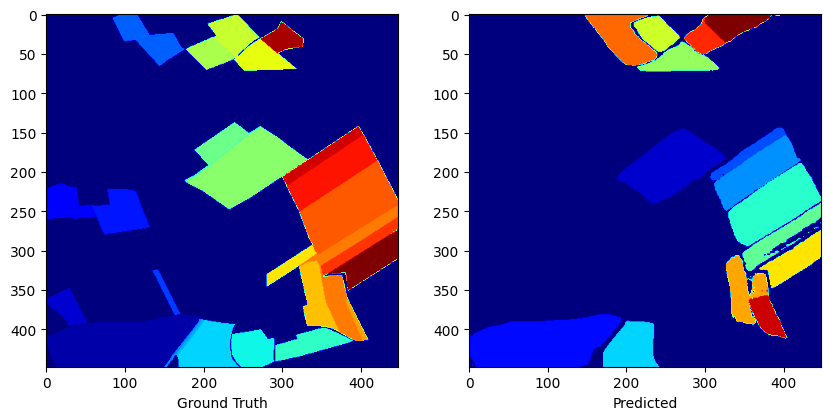

In [13]:
cumulative_high_mask = np.zeros(tuple(rgb_image.size), dtype=np.uint8)

delta_pred_mask = 255 // len(high_res_masks)

for i, mask in enumerate(high_res_masks):
    cumulative_high_mask[mask > 0] = (i + 1)*delta_pred_mask


cumulative_gt_mask = np.zeros(tuple(rgb_image.size), dtype=np.uint8)
delta = 100 // len(target['masks'])

for i, mask in enumerate(target['masks']):
    cumulative_gt_mask[mask > 0] = (i + 1)*delta


#Plot both masks
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(cumulative_gt_mask, cmap='jet')
ax[0].set_xlabel('Ground Truth')

ax[1].imshow(cumulative_high_mask, cmap='jet')
ax[1].set_xlabel('Predicted')

plt.show()